<h1>CWT Demo

In this demo I will show you how to use this code to compute a time-frequency decomposition of a signal (EEG in this case).

In [1]:
!pip install git+https://github.com//Kevin-McIsaac/cmorlet-tensorflow@Tensor-Flow-2.0

  Cloning https://github.com//Kevin-McIsaac/cmorlet-tensorflow (to revision Tensor-Flow-2.0) to /tmp/pip-req-build-6imatw91
  Running command git clone -q https://github.com//Kevin-McIsaac/cmorlet-tensorflow /tmp/pip-req-build-6imatw91
  Running command git checkout -b Tensor-Flow-2.0 --track origin/Tensor-Flow-2.0
  Switched to a new branch 'Tensor-Flow-2.0'
  Branch 'Tensor-Flow-2.0' set up to track remote branch 'Tensor-Flow-2.0' from 'origin'.
  Created wheel for CWT: filename=CWT-2-py3-none-any.whl size=5571 sha256=fb70d0a9ac07dcb01b8c6da3154ae69b5fa62246476cc3d22f893db189887da5
  Stored in directory: /tmp/pip-ephem-wheel-cache-n81e10i6/wheels/dc/a0/f5/80376d80f5ac281273f921ee3d8ec67af981799697f65c9965
Successfully built CWT


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

from CWT.cwt import ComplexMorletCWT

First, we load a demo EEG signal sampled at 200 Hz, so we can compute its CWT.

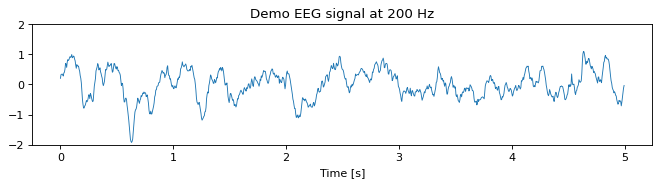

In [4]:
demo_signal = np.loadtxt("https://raw.githubusercontent.com/Kevin-McIsaac/cmorlet-tensorflow/Tensor-Flow-2.0/demo_signal.csv")
fs = 200

n_samples = demo_signal.size
time_axis = np.arange(0, n_samples) / fs

plt.figure(figsize=(10, 2), dpi=80)
plt.plot(time_axis, demo_signal, linewidth=0.8)
plt.title("Demo EEG signal at %d Hz" % fs)
plt.xlabel("Time [s]")
plt.ylim([-2, 2])
plt.show()

Let's compute its Continuous Wavelet Transform (CWT) using some mother wavelet $\psi(t)$. The CWT at scale $s$ of an input signal $x(t)$ is computed by convolving $x(t)$ with a scaled version of the mother wavelet, $\psi_s(t)$, as
$$ \mathrm{CWT}[x](s, t) = \int x(\tau) \psi^*_s(t-\tau)d\tau , $$
where $\psi^*_s$ is the complex conjugate of $\psi_s$, and
$$ \psi_s(t) = \frac{1}{s}\psi\left(\frac{t}{s}\right) $$
Technical note: Here we have chosen L1 normalization (normalizing by $s$) instead of L2 normalization (normalizing by $\sqrt{s}$) because it makes more sense for time-frequency decomposition. L1 normalization allows unity filter gain at each central frequency that is associated with each scale.

As our mother wavelet, we use the popular complex Morlet to capture both amplitude and phase information. The morlet is essentially a sinusoid with a gaussian window. In this implementation, I have chosen the following parameterization:
$$\psi(t) = \frac{1}{Z(\beta)} e^{i2\pi t} e^{-t^2/\beta},$$
where $ Z(\beta) = \sqrt{\pi \beta} / 2 $ and $\beta$ is a parameter that determines the wavelet width (more on its role later). In practice, we do not compute continuous integrals, but rather discrete approximations with time steps $\Delta t = 1/f_s$, where $f_s$ is our sampling rate. Therefore, consider instead the discrete variable $k\in\mathbb{Z}$ that represents the discrete sampling of our signal, i.e. the $k$-th sample occurs at $t=k/f_s$. With it, we compute the discrete convolution:
$$ \mathrm{CWT}[x](s, k) = \sum_n x(n)\psi^*_s(k-n) \Delta t.$$

By absorbing the factor $\Delta t$ in the wavelet, the CWT can be computed by processing $x$ with a convolutional operation with kernel given by:
$$\psi_s(k) = \frac{2}{sf_s\sqrt{\pi\beta}} \exp\left(i\frac{2\pi k}{sf_s}\right) \exp\left(-\frac{k^2}{\beta s^2f_s^2}\right)$$

Theoretically, $\psi_s$ has infinite support (it never reaches zero). But it has what we call an effective support since after some time, the wavelet is very very close to zero and we can ignore it. Specifically, we truncate the wavelet to the discrete interval $k\in[-\eta sf_s  \sqrt{4.5\beta},\ \eta sf_s \sqrt{4.5\beta}]$ (we follow a three-sigma rule for this), where $\eta \ge 1$ is a parameter that, if you want, can be set greater than 1 to have a larger interval. Why? This implementation allows you to set $\beta$ as trainable. If you do this, for example as part of your neural network, allowing some extra room for $\beta$ to grow without truncation problems is a good idea. 

You can see from the truncation interval that larger scales $s$ can be associated with very large wavelets, introducing important border effects. For example, if you set $\beta=1$, $s=1$ and $\eta=1$, then the wavelet has a size $2\eta s f_s \sqrt{4.5\beta} + 1 = 849$. We recommend to remove at least half the size of the largest wavelet at each border, in this case 424 samples, to avoid border effects.

The complex morlet $\psi_s(t)$ is a band-pass filter that extracts the maximum power at the frequency $f_c=1/s$. Leveraging this fact, I simplify the specification of the CWT by letting you choose the frequency range, so that scales are computed internally from the given frequency range, and they are equally spaced in a logarithmic axis (they follow a geometric progression). That is to say, the higher the frequency value, the greater the space between subsequent frequencies. This is recommended for wavelet transformations given their time-frequency trade-off.

In summary, you need to specify:
- The wavelet width $\beta$.
- The minimum frequency of the range, $f_{min}$ in Hz.
- The maximum frequency of the range, $f_{max}$ in Hz.
- The total number of scales, $N_{scales}$.
- Whether you want $\beta$ to be trainable (optional, defaults to False). If True, the provided value will be the initialization value.
- The number of samples to be removed at the borders after CWT computation (optional, defaults to 0).
- The factor $\eta$ to increase the size of the truncation interval (optional, defaults to 1).
- You can also specify a stride, but it defaults to 1.

For this demo, let's use 32 scales between 1 Hz and 30 Hz. Since the demo signal has 1000 samples, we expect to have a scalogram of shape (32, 1000, 2), where the last axis represents the real and the imaginary parts. To start, let's set the wavelet width to $\beta=1$.

Note: The class ComplexMorletCWT implements the class ContinuousWaveletTransform that is also specified in the module cwt.py. If you want to implement a CWT with a different wavelet, you can do so by using the parent class ContinuousWaveletTransform taking the class ComplexMorletCWT as an example.

In [5]:
# Parameters CWT
lower_freq = 1
upper_freq = 30
n_scales = 32
wavelet_width = 1

Here we create our layer with the specified parameters.

In [6]:
cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales)

You can inspect the layer's parameters. For example, take a look at the frequency axis. The numbers are in Hz.

In [7]:
print(cwt.frequencies)

[30.         26.88265645 24.0892406  21.58609264 19.34305042 17.33308597
 15.53197985 13.91802927 12.47178665 11.17582519 10.01452897  8.97390473
  8.04141326  7.20581834  6.45705129  5.78608972  5.18484874  4.64608358
  4.16330229  3.73068751  3.34302635  2.99564763  2.68436554  2.40542922
  2.15547758  1.93149877  1.73079393  1.55094462  1.38978371  1.24536927
  1.11596114  1.        ]


And you can take a look at a wavelet. Let's show the 1 Hz wavelet. 1 Hz is associated with the largest scale of the frequency range.

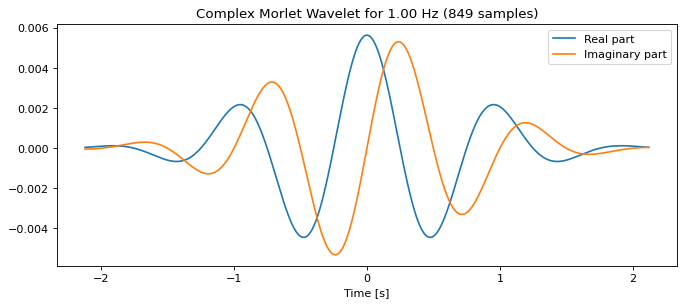

In [9]:
which_scale = -1

real_bank = cwt.real_part
imag_bank = cwt.imaginary_part
single_real_wavelet = real_bank[0, :, 0, which_scale]
single_imag_wavelet = imag_bank[0, :, 0, which_scale]

np_single_real_wavelet = single_real_wavelet.numpy()
np_single_imag_wavelet = single_imag_wavelet.numpy()

single_wavelet_size = np_single_real_wavelet.size
time_axis = np.arange(0, single_wavelet_size) / fs
time_axis = time_axis - np.mean(time_axis)

plt.figure(figsize=(10,4), dpi=80)
plt.plot(time_axis, np_single_real_wavelet, label="Real part")
plt.plot(time_axis, np_single_imag_wavelet, label="Imaginary part")
plt.title("Complex Morlet Wavelet for %1.2f Hz (%d samples)" % (cwt.frequencies[which_scale], single_wavelet_size))
plt.legend()
plt.xlabel("Time [s]")
plt.show()

Now, we will use the wavelets to compute the scalogram of the demo signal. The implementation supports a batch of signals with channels and dtype float32, that is, a tensor of shape (batch size, signal length, number of channels). For our demo, we need to reshape the signal to (1, signal length, 1) and change the dtype from float64 to float32.

In [12]:
# reshape and change dtype
prepared_signal = demo_signal.reshape((1, -1, 1)).astype(np.float32)
# compute the scalogram with the created cwt layer
#scalogram = cwt(prepared_signal)
np_scalogram = cwt(prepared_signal).numpy()

Let's see our result. Remember that the CWT produces a complex scalogram. We can visualize the real and the imaginary parts separately, and we can also compute its magnitude.

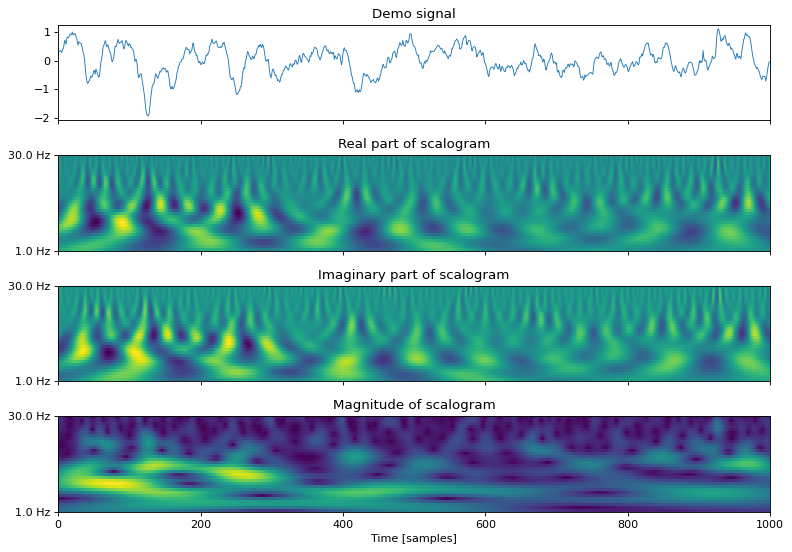

In [13]:
scalogram_real = np_scalogram[0, :, :, 0]
scalogram_imag = np_scalogram[0, :, :, 1]
scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)

# useful for y-axis specs
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, axes = plt.subplots(4, 1, figsize=(10, 7), dpi=80, sharex=True)
axes[0].plot(demo_signal, linewidth=0.8)
axes[0].set_title("Demo signal")
axes[1].imshow(scalogram_real.T, interpolation="none", aspect="auto", extent=[0, scalogram_real.shape[0], 0, 1])
axes[1].set_title("Real part of scalogram")
axes[1].set_yticks(chosen_freq_pos)
axes[1].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[2].imshow(scalogram_imag.T, interpolation="none", aspect="auto", extent=[0, scalogram_imag.shape[0], 0, 1])
axes[2].set_title("Imaginary part of scalogram")
axes[2].set_yticks(chosen_freq_pos)
axes[2].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[3].imshow(scalogram_magn.T, interpolation="none", aspect="auto", extent=[0, scalogram_magn.shape[0], 0, 1])
axes[3].set_title("Magnitude of scalogram")
axes[3].set_yticks(chosen_freq_pos)
axes[3].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[3].set_xlabel("Time [samples]")
plt.tight_layout()
plt.show()

Remember that you have the option of cropping the borders, to avoid border effects for the larger wavelets. Since our largest wavelet has 849 samples, let's crop 424 samples. Therefore, now we expect a scalogram of shape (32, 152, 2). It is very small! If you want to avoid border effects, the proper approach would be to compute the CWT on a larger signal than the one you are interested in, so that after removing the borders you end up with the size you initially wanted.

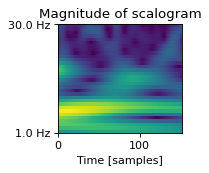

In [15]:
cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=424)
np_scalogram = cwt(prepared_signal).numpy()

scalogram_real = np_scalogram[0, :, :, 0]
scalogram_imag = np_scalogram[0, :, :, 1]
scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)

# useful for y-axis specs
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, ax = plt.subplots(1, 1, figsize=(2, 1.8), dpi=80)
ax.imshow(scalogram_magn.T, interpolation="none", aspect="auto", extent=[0, scalogram_magn.shape[0], 0, 1])
ax.set_yticks(chosen_freq_pos)
ax.set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
ax.set_title("Magnitude of scalogram")
ax.set_xlabel("Time [samples]")
plt.show()

You can also compute the CWT with a stride in the time domain, to save computation. For simplicity, we do not remove borders now, and let's compute the CWT every 10 samples. We expect a scalogram of shape (32, 100, 2). Compare the result with the one obtained without stride. You can recognize the same general trends, but with lower resolution.

The result has shape (1, 100, 32, 2)


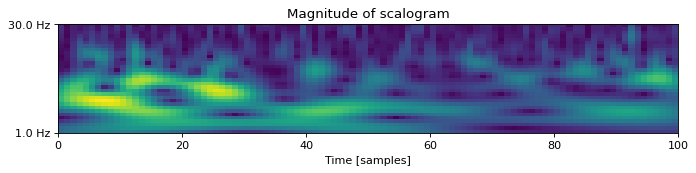

In [16]:
cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=0, stride=10)
np_scalogram = cwt(prepared_signal).numpy()
print("The result has shape", np_scalogram.shape)

scalogram_real = np_scalogram[0, :, :, 0]
scalogram_imag = np_scalogram[0, :, :, 1]
scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)

# useful for y-axis specs
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, ax = plt.subplots(1, 1, figsize=(10, 1.8), dpi=80)
ax.imshow(scalogram_magn.T, interpolation="none", aspect="auto", extent=[0, scalogram_magn.shape[0], 0, 1])
ax.set_yticks(chosen_freq_pos)
ax.set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
ax.set_title("Magnitude of scalogram")
ax.set_xlabel("Time [samples]")
plt.show()

Finally, you can experiment with different wavelet widths to see the effect of the time-frequency trade-off. In general, increasing $\beta$ allows you to have better frequency localization, but you loose temporal localization.

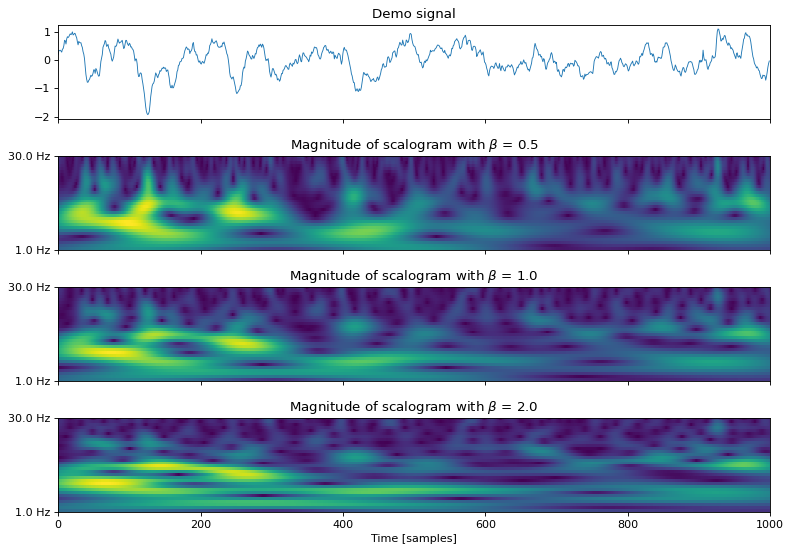

In [17]:
wavelet_width_list = [0.5, 1.0, 2.0]
scalograms_list = []
for wavelet_width in wavelet_width_list:
    cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=0, stride=1)
    np_scalogram = cwt(prepared_signal).numpy()

    scalogram_real = np_scalogram[0, :, :, 0]
    scalogram_imag = np_scalogram[0, :, :, 1]
    scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)
    scalograms_list.append(scalogram_magn)

# useful for y-axis specs
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, axes = plt.subplots(4, 1, figsize=(10, 7), dpi=80, sharex=True)
axes[0].plot(demo_signal, linewidth=0.8)
axes[0].set_title("Demo signal")

axes[1].imshow(
    scalograms_list[0].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[0].shape[0], 0, 1])
axes[1].set_yticks(chosen_freq_pos)
axes[1].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[1].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[0])

axes[2].imshow(
    scalograms_list[1].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[1].shape[0], 0, 1])
axes[2].set_yticks(chosen_freq_pos)
axes[2].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[2].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[1])

axes[3].imshow(
    scalograms_list[2].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[2].shape[0], 0, 1])
axes[3].set_yticks(chosen_freq_pos)
axes[3].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[3].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[2])

axes[3].set_xlabel("Time [samples]")
plt.tight_layout()
plt.show()

The trade-off is better observed with the following synthetic signal that is based on a 13 Hz oscillation.

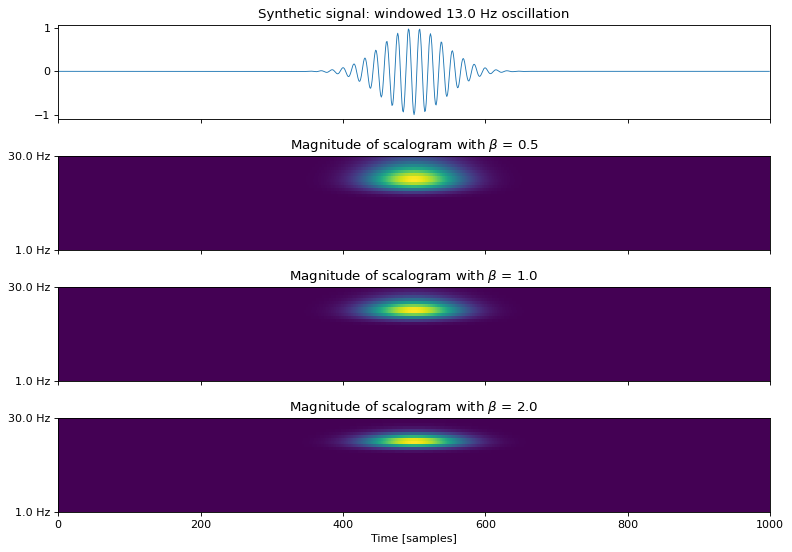

In [19]:
n_samples = 1000
central_freq = 13  # Hz
time_axis = np.arange(n_samples) / fs
oscill = np.cos(2 * np.pi * central_freq * time_axis)
window = np.exp(- (time_axis - np.mean(time_axis)) ** 2 / 0.1)
synt_signal = oscill * window 

prepared_synt_signal = synt_signal.reshape((1, -1, 1)).astype(np.float32)

wavelet_width_list = [0.5, 1.0, 2.0]
scalograms_list = []
for wavelet_width in wavelet_width_list:
    cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=0, stride=1)
    np_scalogram = cwt(prepared_synt_signal).numpy()
    scalogram_real = np_scalogram[0, :, :, 0]
    scalogram_imag = np_scalogram[0, :, :, 1]
    scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)
    scalograms_list.append(scalogram_magn)

# useful for y-axis specs
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, axes = plt.subplots(4, 1, figsize=(10, 7), dpi=80, sharex=True)
axes[0].plot(synt_signal, linewidth=0.8)
axes[0].set_title("Synthetic signal: windowed %1.1f Hz oscillation" % central_freq)

axes[1].imshow(
    scalograms_list[0].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[0].shape[0], 0, 1])
axes[1].set_yticks(chosen_freq_pos)
axes[1].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[1].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[0])

axes[2].imshow(
    scalograms_list[1].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[1].shape[0], 0, 1])
axes[2].set_yticks(chosen_freq_pos)
axes[2].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[2].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[1])

axes[3].imshow(
    scalograms_list[2].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[2].shape[0], 0, 1])
axes[3].set_yticks(chosen_freq_pos)
axes[3].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[3].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[2])

axes[3].set_xlabel("Time [samples]")
plt.tight_layout()
plt.show()